In [1]:
import requests

url = "https://alpha-vantage.p.rapidapi.com/query"

querystring = {"interval":"5min","function":"TIME_SERIES_INTRADAY","symbol":"MSFT","datatype":"json","output_size":"compact"}

headers = {
	"X-RapidAPI-Key": "dd047c0d93msha6f460fc2d73caep10d4f4jsn6fc62458ed4f",
	"X-RapidAPI-Host": "alpha-vantage.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from datetime import datetime

class ScriptData:
    def __init__(self,script):
        self.script=script
        self.fetch_intraday_data()

    def fetch_intraday_data(self):
        querystring['symbol']=self.script
        response = requests.request("GET", url, headers=headers, params=querystring)
        #print(type(response.text))
        self.data = json.loads(response.text)["Time Series (5min)"]
        #print(type(self.data))
        self.convert_intraday_data()
        

    def convert_intraday_data(self):
        data = pd.DataFrame.from_dict(self.data, orient="index")
        data.reset_index(inplace=True)
        data = data.rename(columns={"index": "timestamp", "1. open": "open", "2. high": "high", "3. low": "low", "4. close": "close", "5. volume": "volume"})
        data["timestamp"] = pd.to_datetime(data["timestamp"])
        data["open"] = pd.to_numeric(data["open"])
        data["high"] = pd.to_numeric(data["high"])
        data["low"] = pd.to_numeric(data["low"])
        data["close"] = pd.to_numeric(data["close"])
        data["volume"] = pd.to_numeric(data["volume"])
        self.df = data
        #print(self.df)

    def __getitem__(self, key):
        return self.df

    def __setitem__(self, key, value):
        self.df[key] = value

    def __contains__(self, key):
        return key in self.df.columns


In [3]:
def indicator1(df,timeperiod=5):
    
    new_df =pd.DataFrame()
    new_df['indicator']=None
    value=0.0
    for index, row in df.iterrows():
        value+=df.iloc[index]['close']
        if index>4:
            value-=df.iloc[index-5]['close']
            new_df.loc[index,'indicator']=value/5
        #print(new_df.iloc[index]['indicator'])
    return new_df['indicator']
#indicator1(sd["AAPL"],timeperiod=5)

In [4]:
class Strategy:
    def __init__(self, script_name):
        self.script_name=script_name
        self.script_data = ScriptData(script_name)
    
    def compute_indicator_data(self):
        # Compute indicator data on 'close' of 'df' using indicator1 function.
        self.script_data.df['indicator'] = indicator1(self.script_data[self.script_name],timeperiod=5)
    
    def generate_signals(self):
        signals = pd.DataFrame({'timestamp': self.script_data.df['timestamp']})
        signals['signal'] = 'NO_SIGNAL'
        
        # Identify where the indicator data crosses the close data
        for i in range(1, len(self.script_data.df)):
            if self.script_data.df['indicator'][i] > self.script_data.df['close'][i] and self.script_data.df['indicator'][i-1] <= self.script_data.df['close'][i-1]:
                signals.loc[i, 'signal'] = 'BUY'
            elif self.script_data.df['indicator'][i] < self.script_data.df['close'][i] and self.script_data.df['indicator'][i-1] >= self.script_data.df['close'][i-1]:
                signals.loc[i, 'signal'] = 'SELL'
        
        return signals
    def plotting(self):
        merged_df = pd.merge(self.script_data.df,self.generate_signals(), on='timestamp')
        merged_df.plot(x='timestamp', y=['close', 'indicator'], kind='line',figsize=(10, 5))
        plt.show()





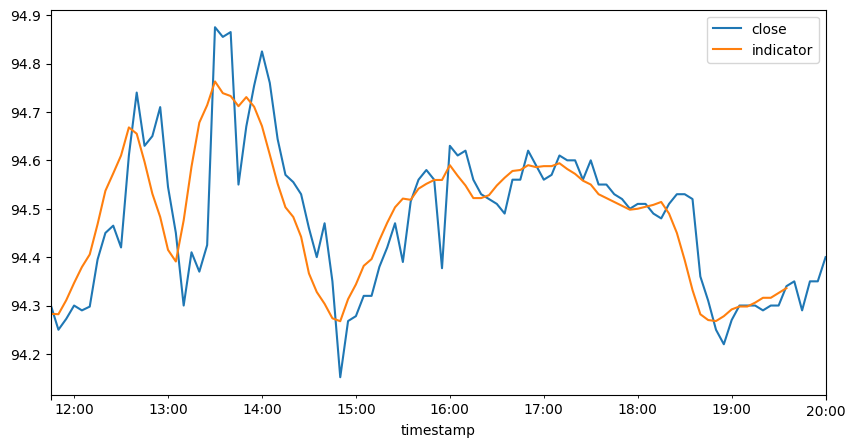

             timestamp     signal
0  2023-02-13 20:00:00  NO_SIGNAL
1  2023-02-13 19:55:00  NO_SIGNAL
2  2023-02-13 19:50:00  NO_SIGNAL
3  2023-02-13 19:45:00  NO_SIGNAL
4  2023-02-13 19:40:00  NO_SIGNAL
5  2023-02-13 19:35:00  NO_SIGNAL
6  2023-02-13 19:30:00        BUY
7  2023-02-13 19:25:00  NO_SIGNAL
8  2023-02-13 19:20:00  NO_SIGNAL
9  2023-02-13 19:15:00  NO_SIGNAL
10 2023-02-13 19:10:00       SELL
11 2023-02-13 19:05:00  NO_SIGNAL
12 2023-02-13 19:00:00        BUY
13 2023-02-13 18:55:00  NO_SIGNAL
14 2023-02-13 18:50:00  NO_SIGNAL
15 2023-02-13 18:45:00       SELL
16 2023-02-13 18:40:00  NO_SIGNAL
17 2023-02-13 18:35:00  NO_SIGNAL
18 2023-02-13 18:30:00  NO_SIGNAL
19 2023-02-13 18:25:00  NO_SIGNAL
20 2023-02-13 18:20:00  NO_SIGNAL
21 2023-02-13 18:15:00        BUY
22 2023-02-13 18:10:00  NO_SIGNAL
23 2023-02-13 18:05:00       SELL
24 2023-02-13 18:00:00  NO_SIGNAL
25 2023-02-13 17:55:00  NO_SIGNAL
26 2023-02-13 17:50:00  NO_SIGNAL
27 2023-02-13 17:45:00  NO_SIGNAL
28 2023-02-13 

In [5]:
pd.set_option('display.max_rows', None)
strategy=Strategy("GOOGL")
strategy.compute_indicator_data()
strategy.plotting()
result=strategy.generate_signals()
print(result)